# An RBC model

In this notebook we show how to solve a simple RBC model in sequence space.

In [20]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## Three Equation NK Model


Let's consider the three equation NK Model

$$
\textbf{H}_t(\textbf{Y}, \hat{a}) \equiv 
\begin{pmatrix}
\hat{y_t}+\sigma[\hat{i_t}-\hat{\pi_{t+1}}]-\hat{y_{t+1}} \\
 \hat{\pi_t}-\kappa(\hat{y_t}-\hat{y_t^{flex}})-\beta \hat{\pi_{t+1}}\\
\hat{i_t}-\phi_{\pi} \hat{\pi_t}\\
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \end{pmatrix},
\qquad t = 0, 1, \dots 
\tag{1}
$$
where $\textbf{Y} = \{\hat{y}, \hat{\pi}, \hat{i} \}$ denotes the set of endogenous variables, and $\hat{a}$ is the only exogenous variable, which determines $\hat{y_t^{flex}}$ through the equation $\hat{y_t^{flex}}=\frac{1+\varphi}{\gamma+\varphi} \hat{a_t}$

#### The NK DAG
The 3 equations of the NK model can be organized as three blocks which form a DAG in one unknown $\mathbf{U} = \mathbf{\hat{i}}$ and one target, the IS curve. 

1. IS Curve:
    - $\hat{y_t}=-\sigma [\hat{i_t}-\hat{\pi_{t+1}}]+\hat{y_{t+1}}$
2. Phillips Curve:
   - $\hat{\pi_t}=\kappa (\hat{y_t}-\hat{y_t^{flex}})+\beta \hat{\pi_{t+1}}$
3. Taylor Rule:
   - $\hat{i_t}=\phi_{\pi} \hat{\pi_t}$

The DAG captures the following logic: given $\mathbf{U} = \mathbf{\hat{n}}$ we can solve for for $\mathbf{\hat{y}}$, and $\mathbf{\hat{w}-\hat{p}}$ in the firm block. Then given $\mathbf{U}$ and $\mathbf{\hat{w}-\hat{p}}$, we solve for $\mathbf{\hat{c}}$ in the household block. Finally, we verify that our sequences are consistent with market clearing in the market clearing block.

The image below shows a visualization of the DAG.


![title](NKDAG.png)

We write the reduced system as
$$
\textbf{H}_t(\textbf{U}, \hat{a}) = 0
$$

We next set up the matrices as we did in class. First define the parameters.

In [21]:
gamma = 1
beta = 0.95
phi = 1
sigma=1
phipi=1.5
kappa=.5
T = 100

Next we set up the matrices in the market clearing block, which we use to construct $\partial \mathbf{H}/ \partial \mathbf{Y}$.

In [22]:
# define sparse identity, above-diagonal sparse matrix, below-diagonal sparse matrix, and zero matrix
I = sp.sparse.eye(T)
Ip1 = sp.sparse.diags([np.ones(T-1)], [1], (T, T)) # identity matrix with 1s above main diagonal
Im1 = sp.sparse.diags([np.ones(T-1)], [-1], (T, T)) # identity matrix with 1s below main diagonal
Z = sp.sparse.csr_matrix((T, T))

# IS Curve
ISPhiy=I-Ip1
#ISPhii=sigma*I
ISPhipi=-sigma*Ip1


#Phigmc = I
#Phigmy = -I
#Phigmwp = Z
#print(Phigmwp.shape)

# combine matrix blocks in a single sparse matrix with the following structure:
# [Phigmc Phigmy Phigmwp]
# [Phieulc Phieuli Phieuly Phieulrk Phieulwp]
dHdY = sp.sparse.bmat([[ISPhiy, ISPhipi]])
assert dHdY.shape == (T,2*T)

Next we construct $\partial \mathbf{Y} / \partial \mathbf{U}$ and $\partial \mathbf{Y} / \partial \mathbf{Z}$ using the blocks. Start with the Taylor Rule.

In [23]:
# firm block matrices: output
TPhii = (1/phipi)*I
#Phiyn = I

# firm block matrices: labor demand
#Phiwpa = I

# combine firm matrices in the following format:
# [Phiyk Phiyn]
# [Phirkk Phirkn]
# [Phiwpk Phiwpn]
dYFdU = sp.sparse.bmat([[TPhii]])
                      
# combine firm matrices in the following format:
# [Phiya]
# [Phiwpa]
# [Phirka]
#dYFdZ = sp.sparse.bmat([[Phiya],[Phiwpa]])
dYFdZ=Z

assert dYFdU.shape == (T, T)
assert dYFdZ.shape == (T, T)

Then move on to the Phillips Curve.

In [24]:
# household block matrix: labor supply
PCPhipi =((1/kappa)*I - (beta/kappa)*Ip1)*TPhii
PCPhia = (1+phi)/(gamma+phi) * I

# combine household matrices in the following format:
# [Phick Phicn]
# [Phiik Phiin]
dYHdU = sp.sparse.bmat([[PCPhipi]])

# combine household matrices in the following format:
# [Phick Phicn]
# [Phiik Phiin]
dYHdZ = sp.sparse.bmat([[PCPhia]])

assert dYHdU.shape == (T, T)
assert dYHdZ.shape == (T, T)

Now stack the household block on top of the firm block to get $\partial \mathbf{Y} / \partial \mathbf{U}$ and $\partial \mathbf{Y} / \partial \mathbf{Z}$.

In [25]:
# stack dYHdU on top of dYFdU to get dYdU
dYdU = sp.sparse.bmat([[dYHdU],
                      [dYFdU]])

# stack dYHdZ on top of dYFdZ to get dYdZ
dYdZ = sp.sparse.bmat([[dYHdZ],
                       [dYFdZ]])

assert dYdU.shape == (2*T, T)
assert dYdZ.shape == (2*T, T)

We have everything now to compute the solution.

In [26]:
# compute dHdU using the chain rule dHdU = dHdY @ dYdU (@ is the python matrix multiplication operator)
dHdU = dHdY @ dYdU 

# compute dHdZ using the chain rule dHdZ = dHdY @ dYdZ (@ is the python matrix multiplication operator)
dHdZ = dHdY @ dYdZ

assert sp.sparse.issparse(dHdZ) == True
assert sp.sparse.issparse(dHdU) == True

assert dHdU.shape == (T, T)
assert dHdZ.shape == (T, T)

# compute the Jacobian of the model
dUdZ = - sp.sparse.linalg.spsolve(dHdU, dHdZ)
dYdZ = dYdU @ dUdZ + dYdZ

dXdZ = sp.sparse.bmat([[dUdZ],
                      [dYdZ]])

assert dUdZ.shape == (T, T)
assert dYdZ.shape == (2*T, T)
assert dXdZ.shape == (3*T, T)

/Users/rileylewers/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:394: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/Users/rileylewers/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:285: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Plot IRF for an AR(1) TFP shock with persistence rho

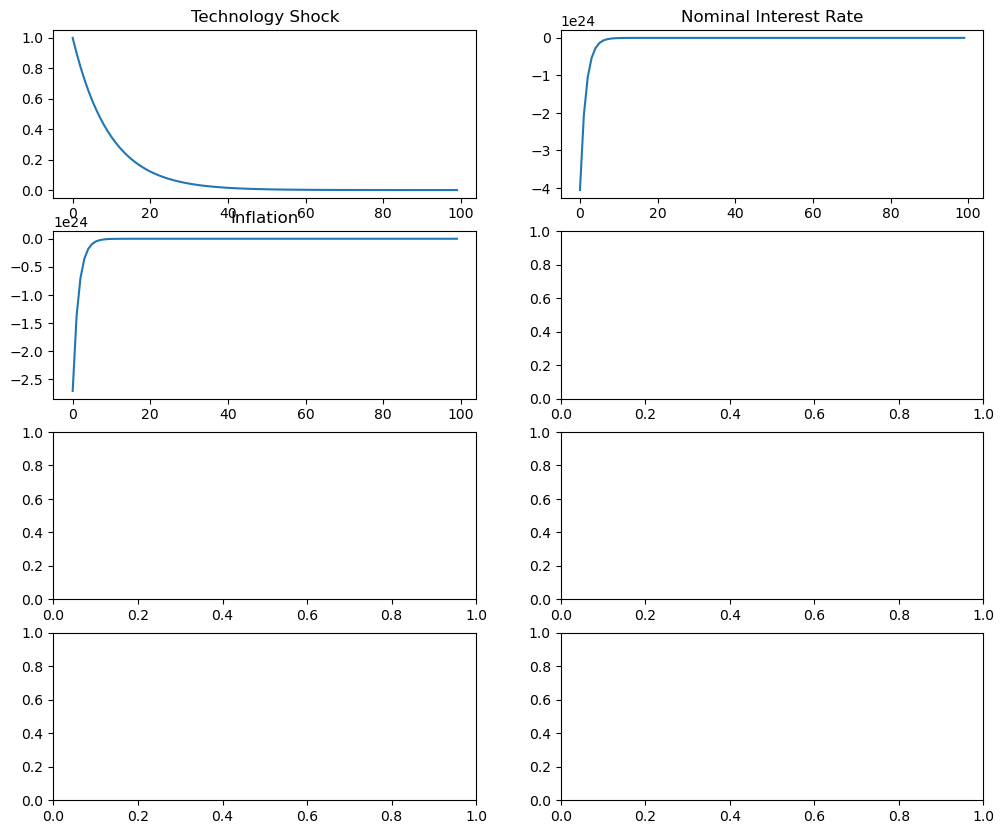

In [27]:
# plot IRFs to TFP shock with persistence rho
rho = 0.9
a = np.zeros((T, 1))
a[0] = 1
for t in range(1, T):
    a[t] = rho * a[t-1]

# compute impulse response functions
X = dXdZ @ a

# unpack X into its components n,c,y,wp,rk
i = X[0:T]
y = X[T:2*T]
pi = X[2*T:3*T]
    
# plot impulse response functions
fig, ax = plt.subplots(4, 2, figsize=(12, 10))
ax[0, 0].plot(a, label='a')
ax[0, 0].set_title('Technology Shock')
ax[0, 1].plot(i, label='i')
ax[0, 1].set_title('Nominal Interest Rate')
ax[1, 0].plot(pi, label='pi')
ax[1, 0].set_title('Inflation')
plt.savefig('IRFs.png')

